In [1]:
#!git clone https://github.com/timesler/facenet-pytorch.git facenet_pytorch

In [2]:
#!pip install .

In [3]:
#!pip install facenet-pytorch

In [4]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import pandas as pd
import os

workers = 0 if os.name == 'nt' else 4

C:\Users\zhang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cpu


In [6]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [7]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

In [8]:
def collate_fn(x):
    return x[0]

dataset = datasets.ImageFolder(r'C:\Users\zhang\Downloads\githubdepression\githubdepression\implementation\facenet_pytorch\data\test_images')
#dataset = datasets.ImageFolder('/Users/mac/Desktop/githubdepression/implementation/images')
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

In [9]:
dataset.idx_to_class

{0: 'angelina_jolie',
 1: 'bradley_cooper',
 2: 'kate_siegel',
 3: 'paul_rudd',
 4: 'shea_whigham'}

In [10]:
print(type(dataset.idx_to_class))

<class 'dict'>


In [11]:
"""
a=dataset.idx_to_class.values()
b=['48','23','25','11','25']
c=dict(zip(b,a))
print(c)
"""
    

"\na=dataset.idx_to_class.values()\nb=['48','23','25','11','25']\nc=dict(zip(b,a))\nprint(c)\n"

In [12]:
aligned = []
names = []
for x, y in loader:
    x_aligned, prob = mtcnn(x, return_prob=True)
    if x_aligned is not None:
        print('Face detected with probability: {:8f}'.format(prob))
        aligned.append(x_aligned)
        names.append(dataset.idx_to_class[y])

Face detected with probability: 0.999983
Face detected with probability: 0.999934
Face detected with probability: 0.999733
Face detected with probability: 0.999876
Face detected with probability: 0.999992


In [13]:
aligned = torch.stack(aligned).to(device)
embeddings = resnet(aligned).detach().cpu()

dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in embeddings]
print(pd.DataFrame(dists, columns=names, index=names))

                angelina_jolie  bradley_cooper  kate_siegel  paul_rudd  \
angelina_jolie        0.000000        1.447480     0.887728   1.434377   
bradley_cooper        1.447480        0.000000     1.313749   1.011981   
kate_siegel           0.887728        1.313749     0.000000   1.388993   
paul_rudd             1.434377        1.011981     1.388993   0.000000   
shea_whigham          1.399073        1.038684     1.379655   1.104096   

                shea_whigham  
angelina_jolie      1.399073  
bradley_cooper      1.038684  
kate_siegel         1.379655  
paul_rudd           1.104096  
shea_whigham        0.000000  


In [ ]:
#!pip install mmcv

     -------------------------------------- 563.1/563.1 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ------------------------------------- 190.2/190.2 kB 11.2 MB/s eta 0:00:00
     --------------------------------------- 35.6/35.6 MB 10.4 MB/s eta 0:00:00
Using legacy 'setup.py install' for mmcv, since package 'wheel' is not installed.
  Running setup.py install for mmcv: started
  Running setup.py install for mmcv: finished with status 'done'


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [17]:
from facenet_pytorch import MTCNN
import torch
import numpy as np
import mmcv, cv2
from PIL import Image, ImageDraw
from IPython import display

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

mtcnn = MTCNN(keep_all=True, device=device)

Running on device: cpu


In [18]:
import mmcv
video = mmcv.VideoReader(r'C:\Users\zhang\Downloads\githubdepression\githubdepression\implementation\facenet_pytorch\examples\video.mp4')
frames = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in video]

display.Video(r'C:\Users\zhang\Downloads\githubdepression\githubdepression\implementation\facenet_pytorch\examples\video.mp4', width=640)

frames_tracked = []
for i, frame in enumerate(frames):
    print('\rTracking frame: {}'.format(i + 1), end='')
    
    # Detect faces
    boxes, _ = mtcnn.detect(frame)
    
    # Draw faces
    frame_draw = frame.copy()
    draw = ImageDraw.Draw(frame_draw)
    for box in boxes:
        draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6)
    
    # Add to frame list
    frames_tracked.append(frame_draw.resize((640, 360), Image.BILINEAR))
print('\nDone')


Tracking frame: 1

C:\Users\zhang\AppData\Local\Temp\ipykernel_16040\609510554.py:21: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  frames_tracked.append(frame_draw.resize((640, 360), Image.BILINEAR))


Tracking frame: 105
Done


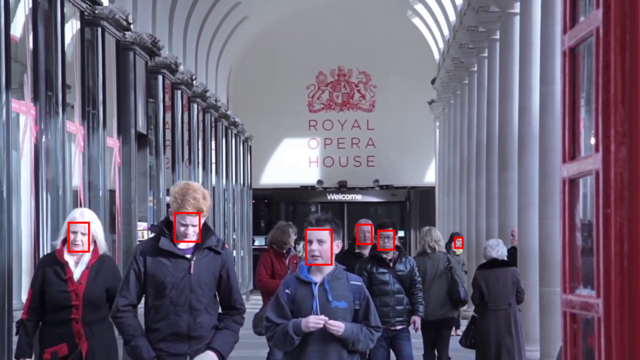

In [ ]:
d = display.display(frames_tracked[0], display_id=True)
i = 1
try:
    while True:
        d.update(frames_tracked[i % len(frames_tracked)])
        i += 1
except KeyboardInterrupt:
    pass

In [19]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import numpy as np
import os


#data_dir = './data/person'
data_dir = r'C:\Users\zhang\Downloads\githubdepression\githubdepression\implementation\facenet_pytorch\data\test_images'
batch_size = 32
epochs = 8
workers = 0 if os.name == 'nt' else 8


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))


mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)



dataset = datasets.ImageFolder(data_dir, transform=transforms.Resize((512, 512)))
dataset.samples = [
    (p, p.replace(data_dir, data_dir + '_cropped'))
        for p, _ in dataset.samples
]
loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    collate_fn=training.collate_pil
)

for i, (x, y) in enumerate(loader):
    mtcnn(x, save_path=y)
    print('\rBatch {} of {}'.format(i + 1, len(loader)), end='')
    
# Remove mtcnn to reduce GPU memory usage
del mtcnn


resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=len(dataset.class_to_idx)
).to(device)

Running on device: cpu
Batch 1 of 1

In [23]:
help(InceptionResnetV1)

Help on class InceptionResnetV1 in module facenet_pytorch.models.inception_resnet_v1:

class InceptionResnetV1(torch.nn.modules.module.Module)
 |  InceptionResnetV1(pretrained=None, classify=False, num_classes=None, dropout_prob=0.6, device=None)
 |  
 |  Inception Resnet V1 model with optional loading of pretrained weights.
 |  
 |  Model parameters can be loaded based on pretraining on the VGGFace2 or CASIA-Webface
 |  datasets. Pretrained state_dicts are automatically downloaded on model instantiation if
 |  requested and cached in the torch cache. Subsequent instantiations use the cache rather than
 |  redownloading.
 |  
 |  Keyword Arguments:
 |      pretrained {str} -- Optional pretraining dataset. Either 'vggface2' or 'casia-webface'.
 |          (default: {None})
 |      classify {bool} -- Whether the model should output classification probabilities or feature
 |          embeddings. (default: {False})
 |      num_classes {int} -- Number of output classes. If 'pretrained' is s

In [22]:
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [5, 10])

trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])
dataset = datasets.ImageFolder(data_dir + '_cropped', transform=trans)
img_inds = np.arange(len(dataset))
print(img_inds)
np.random.shuffle(img_inds)
train_inds = img_inds[:int(0.8 * len(img_inds))]
print(train_inds)
val_inds = img_inds[int(0.8 * len(img_inds)):]
print(val_inds)

train_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(train_inds)
)
val_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(val_inds)
)

[0 1 2 3 4]
[2 0 3 4]
[1]


In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

writer = SummaryWriter()
writer.iteration, writer.interval = 0, 100
#writer.iteration, writer.interval = 0, 100

print('\n\nInitial')
print('-' * 10)
resnet.eval()
training.pass_epoch(
    resnet, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet.train()
    training.pass_epoch(
        resnet, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    resnet.eval()
    training.pass_epoch(
        resnet, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

writer.close()



Initial
----------
Valid |     1/1    | loss:    0.5864 | fps:   11.5253 | acc:    1.0000   

Epoch 1/8
----------
Train |     1/1    | loss:    2.1119 | fps:    5.7791 | acc:    0.0000   
Valid |     1/1    | loss:    3.5605 | fps:   11.9367 | acc:    0.0000   

Epoch 2/8
----------
Train |     1/1    | loss:    0.2730 | fps:    6.9751 | acc:    1.0000   
Valid |     1/1    | loss:    5.3660 | fps:   13.9261 | acc:    0.0000   

Epoch 3/8
----------
Train |     1/1    | loss:    0.0223 | fps:    5.4866 | acc:    1.0000   
Valid |     1/1    | loss:    6.6788 | fps:   14.1215 | acc:    0.0000   

Epoch 4/8
----------
Train |     1/1    | loss:    0.0117 | fps:    7.6105 | acc:    1.0000   
Valid |     1/1    | loss:    7.4707 | fps:   18.5678 | acc:    0.0000   

Epoch 5/8
----------
Train |     1/1    | loss:    0.0019 | fps:    7.2526 | acc:    1.0000   
Valid |     1/1    | loss:    7.0025 | fps:   10.4445 | acc:    0.0000   

Epoch 6/8
----------
Train |     1/1    | loss:    0.0

In [ ]:
import matplotlib
from matplotlib import pylab

Prediction :  paul_rudd , Score:  4.317183
tensor([[3]])


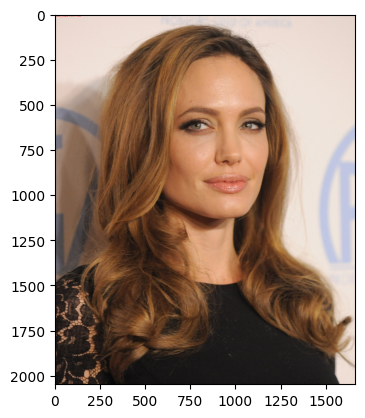

In [ ]:
torch.save(resnet,"face3.pth")

model=torch.load("face3.pth")

import pylab
import matplotlib.pyplot as plt
from PIL import ImageFont, ImageDraw

image_transforms = {
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

dataset = 'C:\\Users\\zhang\\Downloads\\githubdepression\\githubdepression\\implementation\\facenet_pytorch\data\\'
test_directory = os.path.join(dataset, 'test_images')
#test_directory = os.path.join(dataset, 'person')
data = {
    'test_images': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}
batch_size = 32
num_classes = 3
test_data_size = len(data['test_images'])
test_data = DataLoader(data['test_images'], batch_size=batch_size, shuffle=True)
 
idx_to_class = {v: k for k, v in data['test_images'].class_to_idx.items()}
def predict(model, test_image_name):
    transform = image_transforms['test']
 
    test_image = Image.open(test_image_name)
    draw = ImageDraw.Draw(test_image)
 
    test_image_tensor = transform(test_image)
 
    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
 
    with torch.no_grad():
        model.eval()
 
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(1, dim=1)
        print("Prediction : ", idx_to_class[topclass.cpu().numpy()[0][0]], ", Score: ", topk.cpu().numpy()[0][0])
        text = idx_to_class[topclass.cpu().numpy()[0][0]] + " " + str(topk.cpu().numpy()[0][0])
        font = ImageFont.truetype('arial.ttf', 16)
        draw.text((0, 0), text, (255, 0, 0), font=font)
        #test_image.show()
        #plt.show()
        plt.imshow(test_image)
        #pylab.show()
        #print(test_image)
        print(topclass)
#predict(model, './data/four_cropped/he_jiong/he_jiong_0002.jpg')
predict(model, r'C:\Users\zhang\Downloads\githubdepression\githubdepression\implementation\facenet_pytorch\data\test_images\angelina_jolie\1.jpg')
